In [1]:
#@title Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
import os
import pandas as pd
import imageio
from IPython.display import Image
from multiprocessing import Pool
import multiprocessing
number_cpus = multiprocessing.cpu_count()
import shutil
import pathlib
# current directory
current_dir = pathlib.Path().absolute()
# if folder_outputs doesnt exist, create it
folder_outputs = current_dir.joinpath('plots_simulated_cell')
folder_simulated_data = current_dir.joinpath('simulated_data')
# Removing directory if exist
if os.path.exists(folder_outputs):
   shutil.rmtree(folder_outputs)
folder_outputs.mkdir(parents=True, exist_ok=True)
folder_simulated_data.mkdir(parents=True, exist_ok=True) 

In [2]:
# Assign colors to each species for plotting
colors = [ '#FBD148', '#6BCB77', '#AA66CC','#FF6B6B', '#4D96FF']
species_colors = {
    'G_off': colors[0],
    'G_on': colors[1],
    'R_n': colors[2],
    'R_c': colors[3],
    'P':  colors[4]
}

# TODO
- simulate multiple cells to get statistics
- Make this notebook user friendly with description
- Convert the simulation to something more realistic. add noise, use protein count as indicator of protein concentration.
- Add background noise to the simulation.

In [3]:
def plot_time_courses_all_species(trajectories):
    time_steps = trajectories['time_steps']
    # Initialize counts for RNA and Protein, both in cytosol and nucleus
    counts = {
        'RNA': {'cytosol': [0] * len(time_steps), 'nucleus': [0] * len(time_steps)},
        'Protein': {'cytosol': [0] * len(time_steps), 'nucleus': [0] * len(time_steps)}
    }
    # Function to find the index of the closest time step
    def find_closest_time_step_index(target_time):
        return min(range(len(time_steps)), key=lambda i: abs(time_steps[i] - target_time))
    # Process RNA and Protein trajectories
    for entity_type in ['RNA', 'Protein']:
        entity_trajectories = trajectories[f'{entity_type}_trajectories']
        for entity_list in entity_trajectories.values():
            for snapshot in entity_list:
                time_step_index = find_closest_time_step_index(snapshot['time'])
                location = 'cytosol' if snapshot['in_cytosol'] else 'nucleus'
                counts[entity_type][location][time_step_index] += 1
    plt.figure(figsize=(8, 5))
    # Plot RNA in Nucleus
    plt.plot(time_steps, counts['RNA']['nucleus'], label='RNA in Nucleus', linestyle=':', marker='o', color=species_colors['R_n'])
    # Plot RNA in Cytosol
    plt.plot(time_steps, counts['RNA']['cytosol'], label='RNA in Cytosol', linestyle=':', marker='s', color=species_colors['R_c'])
    # plot total RNA
    #plt.plot(time_steps, total_RNA_counts_per_time_step, label='Total RNA', linestyle='-', marker='o', color='y', linewidth=2)
    # Plot total Protein
    #plt.plot(time_steps, total_Protein_counts_per_time_step, label='Total Protein', linestyle='-', marker='o', color=species_colors['P'], linewidth=2)
    # Plot Protein in Nucleus
    #plt.plot(time_steps, counts['Protein']['nucleus'], label='Protein in Nucleus', linestyle='-', marker='o', color='cyan')
    # Plot Protein in Cytosol
    plt.plot(time_steps, counts['Protein']['cytosol'], label='Protein in Cytosol', linestyle='--', marker='s', color=species_colors['P'])
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Molecule Counts', fontsize=14)
    plt.title('Molecule Counts Over Time in Nucleus and Cytosol', fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [5]:
def plot_particle_positions(trajectories, simulation_volume_size, masks_nucleus, masks_cytosol, simulation_type='3D', figsize=(12, 12), time_step_index=None, plot_as_trajectory=True, create_gif=False, elev_val=None, azim_val=None, iteration_index=0, output_folder='temp_plots', show_axes=False, show_time_stamp=False):
    # Decide if the plot should be 2D or 3D based on the simulation type
    is_3D = simulation_type == '3D'
    fig = plt.figure(figsize=figsize)
    if is_3D:
        ax = fig.add_subplot(111, projection='3d', adjustable='box')
    else:
        ax = fig.add_subplot(111)
    # Define colors
    species_colors = {'R_n': 'red', 'P': 'blue'}  # Example colors
    rna_color = species_colors['R_n']
    protein_color = species_colors['P']
    TS_color = 'lime'

    def plot_positions(ax, positions, color, label, is_3D, size=10):
        if positions and len(positions) > 0:
            positions_array = np.array(positions)
            if is_3D:
                xs, ys, zs = positions_array.T
                ax.scatter(xs, ys, zs, color=color, s=size, label=label, depthshade=False)
            else:
                xs, ys = positions_array.T[:2]
                ax.scatter(xs, ys, color=color, s=size, label=label)

    def plot_complete_trajectories(ax, trajectory_data, color, is_3D, markersize=1, linewidth=0.5, time_step_index=None):
        for entity_id, trajectory in trajectory_data.items():
            all_positions = np.array([snapshot['position'] for snapshot in trajectory if time_step_index is None or snapshot['time'] <= time_step_index])
            if len(all_positions) > 1:
                if is_3D:
                    xs, ys, zs = all_positions.T
                    ax.plot(xs, ys, zs, color=color, linestyle='-', marker='o', markersize=markersize, linewidth=linewidth, label=f"ID {entity_id}")
                else:
                    xs, ys = all_positions[:, 0], all_positions[:, 1]
                    ax.plot(xs, ys, color=color, linestyle='-', marker='o', markersize=markersize, linewidth=linewidth, label=f"ID {entity_id}")
            elif len(all_positions) == 1:
                if is_3D:
                    ax.scatter(all_positions[0][0], all_positions[0][1], all_positions[0][2], color=color, s=markersize, label=f"ID {entity_id}")
                else:
                    ax.scatter(all_positions[0][0], all_positions[0][1], color=color, s=markersize, label=f"ID {entity_id}")

    def plot_TS(TS_trajectory, color=TS_color, time_step_index=None, markersize=50):
        if time_step_index is not None:
            ts_data = [data for data in TS_trajectory if data['time'] <= time_step_index]
        else:
            ts_data = TS_trajectory
        for ts_info in ts_data:
            position = ts_info['position']
            ts_color = color if ts_info['state'] else 'gray'
            if is_3D:
                ax.scatter(*position, color=ts_color, s=markersize, label='TS', edgecolor='black', zorder=5)
            else:
                ax.scatter(*position[:2], color=ts_color, s=markersize, label='TS', edgecolor='black', zorder=5)

    def plot_surface_or_contour(ax, mask, color, is_3D):
        if is_3D:
            verts, faces, _, _ = measure.marching_cubes(mask, level=0.5, spacing=(1, 1, 1), step_size=1)
            ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2], color=color, lw=0.1, alpha=0.02)
        else:
            contours = measure.find_contours(mask, level=0.5)
            for contour in contours:
                ax.plot(contour[:, 0], contour[:, 1], color=color, linewidth=2)

    def get_positions_at_time_step(trajectories, time_step_index=None):
        time_steps = trajectories['time_steps']
        RNA_trajectories = trajectories['RNA_trajectories']
        Protein_trajectories = trajectories['Protein_trajectories']
        def extract_positions_at_index(entity_trajectories, target_index):
            positions = []
            for entity_list in entity_trajectories.values():
                for snapshot in entity_list:
                    if snapshot['time'] == time_steps[target_index]:
                        positions.append(snapshot['position'])
            return positions
        if time_step_index is not None and time_step_index < len(time_steps):
            RNA_positions = extract_positions_at_index(RNA_trajectories, time_step_index)
            Protein_positions = extract_positions_at_index(Protein_trajectories, time_step_index)
        else:
            RNA_positions, Protein_positions = [], []
        return RNA_positions, Protein_positions

    plot_surface_or_contour(ax, masks_nucleus, 'lightcoral', is_3D)
    plot_surface_or_contour(ax, masks_cytosol, 'lightgray', is_3D)

    if plot_as_trajectory and time_step_index is not None:
        plot_complete_trajectories(ax=ax, trajectory_data=trajectories['RNA_trajectories'], color=rna_color, is_3D=is_3D, markersize=1, linewidth=0.5, time_step_index=time_step_index)
        plot_complete_trajectories(ax=ax, trajectory_data=trajectories['Protein_trajectories'], color=protein_color, is_3D=is_3D, markersize=0.5, linewidth=0.5, time_step_index=time_step_index)
        plot_TS(trajectories['TS_trajectory'], TS_color, time_step_index=time_step_index, markersize=60)
    elif time_step_index is not None:
        RNA_positions, Protein_positions = get_positions_at_time_step(trajectories, time_step_index)
        plot_positions(ax, RNA_positions, rna_color, 'RNA', is_3D, 20)
        plot_positions(ax, Protein_positions, protein_color, 'Protein', is_3D, 2)
        plot_TS(trajectories['TS_trajectory'], TS_color, time_step_index=time_step_index, markersize=60)
    else:
        plot_complete_trajectories(ax=ax, trajectory_data=trajectories['RNA_trajectories'], color=rna_color, is_3D=is_3D, markersize=1)
        plot_complete_trajectories(ax=ax, trajectory_data=trajectories['Protein_trajectories'], color=protein_color, is_3D=is_3D, markersize=0.5)
        plot_TS(trajectories['TS_trajectory'], TS_color, None, markersize=60)

    if show_time_stamp and time_step_index is not None:
        ax.set_title(f'Time: {time_step_index}', fontsize=14)

    if is_3D and elev_val is not None and azim_val is not None:
        ax.view_init(elev=elev_val, azim=azim_val)

    if not show_axes:
        ax.set_axis_off()
    else:
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        if is_3D:
            ax.set_zlabel('Z')

    ax.set_xlim([0, simulation_volume_size[0]])
    ax.set_ylim([0, simulation_volume_size[1]])
    if is_3D:
        ax.set_zlim([0, simulation_volume_size[2]])

    if create_gif:
        os.makedirs(output_folder, exist_ok=True)
        filepath = os.path.join(output_folder, f'image_{iteration_index:04d}.png')
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0)
        plt.close()
    else:
        plt.show()


In [6]:
def generate_frame(args):
    trajectories, simulation_volume_size, masks_nucleus, masks_cytosol,simulation_type, figsize, time_step_index, output_folder, index, elevation, azimuth, show_axes,show_time_stamp,plot_as_trajectory= args
    # This function will call your existing plotting function with the appropriate arguments for each frame
    plot_particle_positions( trajectories, simulation_volume_size, masks_nucleus, masks_cytosol,simulation_type, figsize, time_step_index, create_gif=True, elev_val=elevation, azim_val=azimuth, iteration_index=index, output_folder=output_folder, show_axes=show_axes,show_time_stamp=show_time_stamp,plot_as_trajectory=plot_as_trajectory)
    return os.path.join(output_folder, f'image_{index:04d}.png')
def generate_gif_multiprocessing( trajectories, simulation_volume_size, masks_nucleus, masks_cytosol, simulation_type, figsize,time_step_index=None, output_folder='temp_plots', number_steps=18, show_axes=False, rotate_gif=False, time_course_gif=False, max_time=False, gif_filename='animation_cell.gif',plot_as_trajectory=False):
    if os.path.exists(output_folder):
        for filename in os.listdir(output_folder):
            os.remove(os.path.join(output_folder, filename))
        os.rmdir(output_folder)
    os.makedirs(output_folder, exist_ok=True)
    if simulation_type == '2D' and rotate_gif:
        raise ValueError("Cannot rotate a 2D simulation. Set rotate_gif=False.")
    args_list = []
    if rotate_gif:
        iteration_vector = np.linspace(0, 360, number_steps).astype(int)
        for index, azimuth in enumerate(iteration_vector):
            args = (trajectories, simulation_volume_size, masks_nucleus, masks_cytosol,simulation_type, figsize, time_step_index, output_folder, index, 25, azimuth, show_axes,False,plot_as_trajectory)
            args_list.append(args)
    if time_course_gif:
        iteration_vector = np.linspace(0, max_time, number_steps).astype(int)
        for index, time_point in enumerate(iteration_vector):
            args = (trajectories, simulation_volume_size, masks_nucleus, masks_cytosol, simulation_type, figsize, time_point, output_folder, index, None, None, show_axes,True,plot_as_trajectory)
            args_list.append(args)
    # Use multiprocessing to generate frames
    with Pool() as pool:
        image_files = pool.map(generate_frame, args_list)
    # Compile the selected images into a GIF
    with imageio.get_writer(gif_filename, mode='I', duration=0.5) as writer:
        for filepath in image_files:
            writer.append_data(imageio.imread(filepath))
    # Optionally, remove the images after creating the GIF
    for filename in os.listdir(output_folder):
        os.remove(os.path.join(output_folder, filename))
    print(f"GIF saved to {gif_filename}")
    return Image(filename=gif_filename)


In [7]:
class GeneExpressionSimulator:
    def __init__(self, params):
        self.TS_state = False  # Initial state of the Transcription Site (TS)
        self.RNAs = {}
        self.Proteins = {}
        self.next_rna_id = 1
        self.next_protein_id = 1
        self.simulation_type = params.get('simulation_type', '3D')  # Default to '3D' if not specified
        dim = 2 if self.simulation_type == '2D' else 3
        simulation_volume_size = params['simulation_volume_size'][:dim]
        center_of_box = np.array(simulation_volume_size) / 2
        self.center_of_box = center_of_box
        self.simulation_volume_size = simulation_volume_size
        self.nucleus_mask = np.zeros(simulation_volume_size, dtype=bool)
        self.cytosol_mask = np.zeros(simulation_volume_size, dtype=bool)
        if params['position_TS']=='center':
            self.transcription_site = center_of_box
        else:
            self.transcription_site = self.find_random_TS_position_inside_nucleus(params)        
        self.RNA_trajectories = {}  # To store RNA positions over time.
        self.Protein_trajectories = {}  # To store Protein positions over time.
        self.frame_rate =  params['frame_rate']    # Save data every 1 second
        self.time_steps = []  # To store time steps at specified frame rate
        self.TS_trajectory = []  # To store TS trajectory with time step and position
        self.transport_rate = params['transport_rate']
        self.small_distance_outside_nucleus = 1 # Small distance outside nucleus for RNA transport
        self.transport_zone_threshold = 2 # Threshold distance for RNA near nuclear envelope, in pixels
        self.simulation_type = params['simulation_type'] # Type of simulation. options: '3D', '2D'
        self.movement_protein_into_nucleus = params['movement_protein_into_nucleus']  # Allow protein movement in nucleus
        if 'burnin_time' in params:
            self.burnin_time = params['burnin_time']# Time to run the simulation without saving data
        else:
            self.burnin_time = 0
            
        self.next_save_time = self.burnin_time   # Time for next save
        self.total_time = params['total_time']+self.burnin_time  # Total time for the simulation
        self.drug_application_time= params['drug_application_time']+self.burnin_time  # Time to apply drug
        # Creating the rates for the model
        self.rates = params.copy()
        # Apply drug effect if specified    
        self.inhibited_parameters= params['inhibited_parameters']
        self.apply_drug = params['apply_drug']   
        self.parameters_updated = False
        
    def update_rates_with_drug_effect(self):
        for param, value in self.inhibited_parameters.items():
            if param in self.rates:
                self.rates[param] = value
    
    def find_random_TS_position_inside_nucleus(self):
        dim = 2 if self.simulation_type == '2D' else 3
        # Adjust for dimensionality of simulation_volume_size
        volume_size = np.array(self.simulation_volume_size[:dim])
        while True:
            random_pos = np.random.rand(dim) * volume_size  # Ensure volume_size matches dimension
            if self.is_within_nucleus({'position': random_pos.tolist()}):
                return random_pos.tolist()
        
    # def save_state(self, current_time):
    #     current_time_int = int(current_time)  # Use float to store precise time, including fractions of seconds
    #     self.time_steps.append(current_time_int)
    #     for rna_id, rna_info in self.RNAs.items():
    #         if rna_id not in self.RNA_trajectories:
    #             self.RNA_trajectories[rna_id] = []
    #         rna_snapshot = rna_info.copy()
    #         rna_snapshot['time'] = current_time_int
    #         rna_snapshot['id'] = rna_id  # Explicitly include 'id'
    #         rna_snapshot['position'] = self.RNAs[rna_id]['position']
    #         self.RNA_trajectories[rna_id].append(rna_snapshot)
    #     for protein_id, protein_info in self.Proteins.items():
    #         if protein_id not in self.Protein_trajectories:
    #             self.Protein_trajectories[protein_id] = []
    #         protein_snapshot = protein_info.copy()
    #         protein_snapshot['time'] = current_time_int
    #         protein_snapshot['id'] = protein_id  # Explicitly include 'id'
    #         protein_snapshot['position'] = self.Proteins[protein_id]['position']
    #         self.Protein_trajectories[protein_id].append(protein_snapshot)
    #     # For the transcription site, if it also has an 'id', include it as well
    #     TS_info = {
    #         'position': self.transcription_site.tolist(),
    #         'state': self.TS_state,
    #         'time': current_time_int
    #     }
    #     self.TS_trajectory.append(TS_info)
    
    def save_state(self, current_time):
        current_time_int = int(current_time - self.burnin_time)  # Adjust time to start from 0 after burnin
        self.time_steps.append(current_time_int)
        
        for rna_id, rna_info in self.RNAs.items():
            if rna_id not in self.RNA_trajectories:
                self.RNA_trajectories[rna_id] = []
            rna_snapshot = rna_info.copy()
            rna_snapshot['time'] = current_time_int
            rna_snapshot['id'] = rna_id
            rna_snapshot['position'] = self.RNAs[rna_id]['position']
            self.RNA_trajectories[rna_id].append(rna_snapshot)
        
        for protein_id, protein_info in self.Proteins.items():
            if protein_id not in self.Protein_trajectories:
                self.Protein_trajectories[protein_id] = []
            protein_snapshot = protein_info.copy()
            protein_snapshot['time'] = current_time_int
            protein_snapshot['id'] = protein_id
            protein_snapshot['position'] = self.Proteins[protein_id]['position']
            self.Protein_trajectories[protein_id].append(protein_snapshot)
        
        # For the transcription site, if it also has an 'id', include it as well
        TS_info = {
            'position': self.transcription_site.tolist(),
            'state': self.TS_state,
            'time': current_time_int
        }
        self.TS_trajectory.append(TS_info)
    
    def generate_masks(self):
        # Generate meshgrid according to the simulation type
        if self.simulation_type == '2D':
            x, y = np.meshgrid(np.linspace(0, self.simulation_volume_size[0] - 1, self.simulation_volume_size[0]),
                            np.linspace(0, self.simulation_volume_size[1] - 1, self.simulation_volume_size[1]),
                            indexing='ij')
            positions = np.stack((x, y), axis=-1)  # Shape: [dim_x, dim_y, 2]
            nucleus_sizes = np.array(self.rates['nucleus_size'][:2]) / 2
            cytosol_sizes = np.array(self.rates['cytosol_size'][:2]) / 2
        else:  # 3D
            x, y, z = np.meshgrid(np.linspace(0, self.simulation_volume_size[0] - 1, self.simulation_volume_size[0]),
                                np.linspace(0, self.simulation_volume_size[1] - 1, self.simulation_volume_size[1]),
                                np.linspace(0, self.simulation_volume_size[2] - 1, self.simulation_volume_size[2]),
                                indexing='ij')
            positions = np.stack((x, y, z), axis=-1)  # Shape: [dim_x, dim_y, dim_z, 3]
            nucleus_sizes = np.array(self.rates['nucleus_size']) / 2
            cytosol_sizes = np.array(self.rates['cytosol_size']) / 2
        # Calculating normalized squared distance for nucleus and cytosol
        center_of_box = self.center_of_box[:positions.shape[-1]]  # Adjust center according to dimensions
        normalized_sq_dist_nucleus = np.sum(((positions - center_of_box) / nucleus_sizes)**2, axis=-1)
        normalized_sq_dist_cytosol = np.sum(((positions - center_of_box) / cytosol_sizes)**2, axis=-1)
        # Creating masks based on the normalized squared distances
        self.nucleus_mask = normalized_sq_dist_nucleus <= 1
        self.cytosol_mask = normalized_sq_dist_cytosol <= 1
        self.cytosol_mask &= ~self.nucleus_mask  

    def is_within_nucleus(self, entity):
        dimension = 2 if self.simulation_type == '2D' else 3
        pos = np.array(entity['position'][:dimension])
        nucleus_size = np.array(self.rates['nucleus_size'][:dimension]) / 2
        center_of_box = self.center_of_box[:dimension]
        normalized_sq_dist = np.sum(((pos - center_of_box) / nucleus_size) ** 2)
        return normalized_sq_dist <= 1
    
    def is_within_cytosol(self, entity):
        dimension = 2 if self.simulation_type == '2D' else 3
        pos = np.array(entity['position'][:dimension])
        cytosol_size = np.array(self.rates['cytosol_size'][:dimension]) / 2
        center_of_box = self.center_of_box[:dimension]
        normalized_sq_dist = np.sum(((pos - center_of_box) / cytosol_size) ** 2)
        is_in_cytosol = normalized_sq_dist <= 1
        return is_in_cytosol and not self.is_within_nucleus(entity)
    
    def move_particle(self, entity, rate):
        dimension = 2 if self.simulation_type == '2D' else 3
        displacement = np.random.normal(scale=np.sqrt(rate), size=dimension)
        current_position = np.array(entity['position'][:dimension])
        new_position = current_position + displacement
        temp_entity = {'position': new_position}
        # RNA specific logic
        if entity['entity_type'] == 'RNA':
            # Check if the RNA is within the cytosol 
            if entity['in_cytosol'] and self.is_within_cytosol(temp_entity):
                entity['position'] = new_position.tolist()
            # Check if the RNA is within the nucleus
            elif not entity['in_cytosol'] and self.is_within_nucleus(temp_entity):
                entity['position'] = new_position.tolist()
            # If RNA is trying to cross from the nucleus to the cytosol without proper transport, ignore
        # Protein specific logic
        elif entity['entity_type'] == 'Protein':
            # Check user permission for protein movement in the nucleus
            if self.movement_protein_into_nucleus:
                # Allow movement in both nucleus and cytosol
                if self.is_within_cytosol(temp_entity) or self.is_within_nucleus(temp_entity):
                    entity['position'] = new_position.tolist()
            else:
                # Restrict movement to the cytosol only
                if self.is_within_cytosol(temp_entity):
                    entity['position'] = new_position.tolist()
                # If the new position is outside the cytosol (and in the nucleus), ignore the move
        return entity
    
    def is_near_nuclear_envelope(self, rna_position):
        dimension = 2 if self.simulation_type == '2D' else 3
        # Adjust the nucleus and shrunk nucleus sizes for the dimension
        nucleus_size = np.array(self.rates['nucleus_size'][:dimension])
        shrunk_nucleus_size = nucleus_size - 2 * self.transport_zone_threshold  # Shrink in all directions
        # Ensure that the shrunk size does not go to zero or negative
        shrunk_nucleus_size = np.clip(shrunk_nucleus_size, a_min=self.transport_zone_threshold, a_max=None)
        pos = np.array(rna_position[:dimension])
        center_of_box = self.center_of_box[:dimension]
        # Calculate if the RNA is within the actual nucleus ellipsoid
        within_nucleus = np.sum(((pos - center_of_box) ** 2) / ((nucleus_size / 2) ** 2)) <= 1
        # Calculate if the RNA is outside the shrunk nucleus (inner boundary)
        outside_shrunk_nucleus = np.sum(((pos - center_of_box) ** 2) / ((shrunk_nucleus_size / 2) ** 2)) > 1
        return within_nucleus and outside_shrunk_nucleus

    def calculate_rates_and_reactions(self):
        rates = []
        reactions = []
        if not self.TS_state:
            rates.append(self.rates['k_on'])
            reactions.append(('TS_on', None))
        else:
            rates.append(self.rates['k_off'])
            reactions.append(('TS_off', None))
            rates.append(self.rates['k_r'])
            reactions.append(('produce_RNA', None))
        for rna_id, rna_info in self.RNAs.items():
            rates.append(self.rates['gamma_r'])
            reactions.append(('degrade_RNA', rna_id))
            rates.append(self.rates['k_diff_r'])
            reactions.append(('move_RNA', rna_id))
            if rna_info['in_cytosol']:
                rates.append(self.rates['k_p'])
                reactions.append(('produce_Protein', rna_id))
            if not rna_info['in_cytosol'] and self.is_near_nuclear_envelope(np.array(rna_info['position'])):
                rates.append(self.rates['transport_rate'])
                reactions.append(('transport_RNA_to_cytosol', rna_id))
        for protein_id in self.Proteins.keys():
            rates.append(self.rates['gamma_p'])
            reactions.append(('degrade_Protein', protein_id))
            rates.append(self.rates['k_diff_p'])
            reactions.append(('move_Protein', protein_id))
        return rates, reactions

    def execute_reaction(self, reaction, current_time):
        reaction_type, entity_id = reaction
        if reaction_type == 'TS_off':
            self.TS_state = False
        elif reaction_type == 'TS_on':
            self.TS_state = True
        
        elif reaction_type == 'produce_RNA':
            # Assuming transcription site is the initial position for RNA
            new_rna = {
                'id': self.next_rna_id,
                'position': self.transcription_site.tolist(),
                'in_cytosol': False,
                'entity_type': 'RNA',
                'time': current_time,
            }
            self.RNAs[self.next_rna_id] = new_rna
            self.next_rna_id += 1
        elif reaction_type == 'degrade_RNA' and entity_id in self.RNAs:
            del self.RNAs[entity_id]
        elif reaction_type == 'move_RNA':
            if entity_id in self.RNAs:
                rna_info = self.RNAs[entity_id]
                self.move_particle(rna_info, self.rates['k_diff_r'])
        elif reaction_type == 'transport_RNA_to_cytosol':
            if entity_id in self.RNAs:
                rna_info = self.RNAs[entity_id]
                rna_info['in_cytosol'] = True
                # Determine dimensionality based on simulation type
                dimension = 2 if self.simulation_type == '2D' else 3
                # Adjust nucleus radius and center_of_box for the dimension
                nucleus_radius = np.array(self.rates['nucleus_size'][:dimension]) / 2
                center_of_box_dim = self.center_of_box[:dimension]
                # Adjust direction_vector calculation for dimensionality
                direction_vector = np.array(rna_info['position'][:dimension]) - center_of_box_dim
                direction_vector /= np.linalg.norm(direction_vector)  # Normalize the vector
                # Calculate new position considering the dimensionality
                new_position = center_of_box_dim + direction_vector * (nucleus_radius + self.small_distance_outside_nucleus)
                # Ensure the new position has the correct dimensionality
                rna_info['position'][:dimension] = new_position.tolist()
        elif reaction_type == 'produce_Protein' and entity_id in self.RNAs:
            # Proteins are produced at the RNA's current position
            protein_info = self.RNAs[entity_id].copy()
            if protein_info['in_cytosol']:  # Ensure Protein is produced only if RNA is in cytosol
                new_protein = {
                    'id': self.next_protein_id,
                    'position': protein_info['position'],
                    'in_cytosol': True, # Proteins once produced are always in cytosol
                    'entity_type': 'Protein',
                    'time': current_time,
                }
                self.Proteins[self.next_protein_id] = new_protein
                self.next_protein_id += 1    
        elif reaction_type == 'degrade_Protein' and entity_id in self.Proteins:
            del self.Proteins[entity_id]
        elif reaction_type == 'move_Protein' and entity_id in self.Proteins:
            protein_info = self.Proteins[entity_id]
            proposed_new_position = self.move_particle(protein_info, self.rates['k_diff_p'])
            # Since proteins are always in the cytosol, we only update if within cytosol
            if self.is_within_cytosol(proposed_new_position):
                self.Proteins[entity_id] = proposed_new_position
            else:
                # If the new position is outside the cytosol, ignore the move
                pass
    
    
    
    # def simulate(self):
    #     parameters_updated=False
    #     current_time = 0
    #     while current_time < self.total_time:
    #         if self.next_save_time >0:
    #             # Determine the time until the next scheduled save state, if any actions will occur before then
    #             rates, reactions = self.calculate_rates_and_reactions()
    #             if not rates:
    #                 # No reactions are pending, directly jump to the next save time if necessary
    #                 if current_time < self.next_save_time and self.next_save_time <= self.total_time:
    #                     current_time = self.next_save_time
    #                 else:
    #                     break  # End simulation if beyond total time and no actions are pending
    #             else:
    #                 # Calculate the next reaction time based on the rates
    #                 time_step = np.random.exponential(1 / sum(rates))
    #                 proposed_next_time = current_time + time_step
    #                 # If the proposed next time exceeds the next save time, adjust it to match exactly
    #                 if proposed_next_time >= self.next_save_time and current_time < self.next_save_time:
    #                     current_time = self.next_save_time
    #                 else:
    #                     current_time = proposed_next_time
    #                 # Execute the reaction if we are proceeding with time advancement
    #                 if current_time <= self.total_time and rates:
    #                     reaction_index = np.random.choice(len(rates), p=np.array(rates) / sum(rates))
    #                     reaction = reactions[reaction_index]
    #                     self.execute_reaction(reaction, current_time)
    #         #else:
    #         #    current_time =0.0001
    #         # updating parameters values to simulate drug effect
    #         if self.apply_drug and current_time >= self.drug_application_time and not parameters_updated:
    #             self.update_rates_with_drug_effect()
    #             parameters_updated = True
    #         # Save state either after a reaction or because it's time
    #         if current_time >= self.burnin_time and current_time >= self.next_save_time:
    #             self.save_state(current_time)
    #             # Update next save time to the next interval
    #             self.next_save_time += self.frame_rate
    #             if self.next_save_time < current_time:
    #                 # Ensure next save time is always ahead of the current time
    #                 self.next_save_time = current_time + self.frame_rate

    def simulate(self):
        current_time = 0
        while current_time < self.total_time:
            # Calculate rates and reactions for the current state
            rates, reactions = self.calculate_rates_and_reactions()
            if not rates:
                # If there are no reactions left, advance to the next significant time point (next save time or total time)
                next_time_point = min(self.next_save_time, self.total_time)
                if current_time < next_time_point:
                    current_time = next_time_point
                else:
                    break  # End simulation if beyond total time and no actions are pending
            else:
                # Determine the time until the next reaction occurs
                time_step = np.random.exponential(1 / sum(rates))
                current_time += time_step
            # Update parameters if the drug application time has been reached and it's not already updated
            if (self.apply_drug==True) and (current_time >= self.drug_application_time) and (self.parameters_updated==False):
                self.update_rates_with_drug_effect()
                self.parameters_updated = True
            # Check if the current time is beyond the burnin time and it's time to save the state
            if current_time >= self.burnin_time and current_time >= self.next_save_time:
                self.save_state(current_time)
                self.next_save_time += self.frame_rate  # Schedule the next state save
            # Execute any reactions that were supposed to happen at this time
            if rates:
                reaction_index = np.random.choice(len(rates), p=np.array(rates) / sum(rates))
                reaction = reactions[reaction_index]
                self.execute_reaction(reaction, current_time)



    def run(self):
        self.simulate()
        self.generate_masks()
        #RNAs_positions = self.RNA_trajectories
        #Proteins_positions = self.Protein_trajectories 
        return {
            #'RNAs': RNAs_positions,
            #'Proteins': Proteins_positions,
            'RNA_trajectories': self.RNA_trajectories,
            'Protein_trajectories': self.Protein_trajectories,
            'TS_trajectory': self.TS_trajectory,
            'nucleus_mask': self.nucleus_mask,
            'cytosol_mask': self.cytosol_mask,
            'time_steps': self.time_steps,  # Include time_steps in the returned dictionary
        }

In [8]:
k_on = 0.5
k_off = 0.1
k_r = 3
k_p = 0.9
gamma_r = 0.05 # assuming gamma_rn = gamma_rc
gamma_p = 0.6
transport_rate = 1 # fixing the transport rate for this model
diffusion_rate = 10 # assuming diffusion_rate_r = diffusion_rate_p
total_simulation_time = 201
nucleus_diameter = 40
number_of_trajectories = number_cpus
cytosol_diameter = 70
model_type = '3D'
# simulating inhibition 
apply_drug =True
drug_application_time = 100
inhibition_constant = 0.1
inhibited_parameters={'transport_rate': transport_rate*inhibition_constant}

# adding burnin time to allow the system to reach steady state
burnin_time = 100


In [9]:
# Example of setting up and running the simulation
params = {
        'k_on': k_on, 
        'k_off': k_off,
        'k_r': k_r, 
        'gamma_r': gamma_r,
        'k_p': k_p,
        'gamma_p': gamma_p,
        'k_diff_r': diffusion_rate, 
        'k_diff_p': diffusion_rate,
        'transport_rate':transport_rate,
        'nucleus_size': [nucleus_diameter]*3,  # Assuming spherical shapes for simplicity. Diameter
        'cytosol_size': [cytosol_diameter]*3,  # Assuming spherical shapes for simplicity . Diameter
        'total_time': total_simulation_time,
        'simulation_volume_size': [100,100,100], # 3D simulation size
        'simulation_type': '2D', # options are '2D' or '3D'
        'frame_rate' : 1,
        'movement_protein_into_nucleus' : False,  # Allow protein movement in nucleus
        'position_TS':'center', # options are 'center' or 'random'
        'apply_drug': apply_drug,
        'drug_application_time': drug_application_time,
        'inhibited_parameters':inhibited_parameters,
        'burnin_time': burnin_time,
}



In [10]:
# running the example simulation
simulator = GeneExpressionSimulator(params)
results = simulator.run()

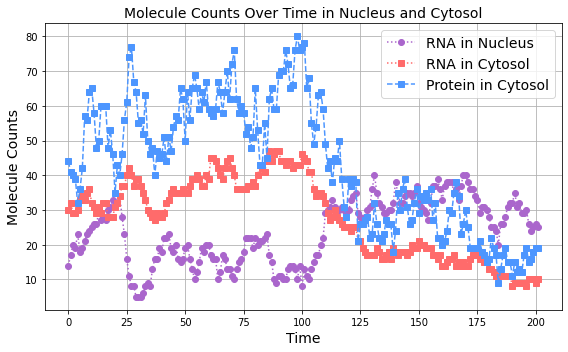

In [11]:
plot_time_courses_all_species(trajectories=results)

## Diffusion Time to the Cytosol
____

To estimate the diffusion time for an RNA molecule to reach the periphery of the nucleus from its point of transcription, we can use the principle of diffusion. <br />
The mean squared displacement ($ \langle r^2 \rangle $) over time ($t$) for a particle undergoing Brownian motion is given by:

$$
\langle r^2 \rangle = nDt
$$

where $n$ is the number of physical dimensions, $D$ is the diffusion coefficient in units of area per time, and $r$ is the distance from the starting point.

### Example Calculation:

Given a nucleus radius ($r$) of $40$ pixels and a diffusion coefficient of the RNA molecule ($D$) of 10 $\text{pixels}^2$/s, first, 
we convert $r$ to the mean squared displacement ($\langle r^2 \rangle$):

$$
\langle r^2 \rangle = r^2 = (40 \, \text{pixels})^2 = 1600 \, \text{pixels}^2
$$

Then, calculate $t$ for both cases:

#### For 3D:

$$
t_{3D} = \frac{1600 \, \text{pixels}^2}{6 \times 10 \, \text{pixels}^2/s} = \frac{1600}{60} s \approx 26.67 s
$$

#### For 2D:

$$
t_{2D} = \frac{1600 \, \text{pixels}^2}{4 \times 10 \, \text{pixels}^2/s} = \frac{1600}{40} s = 40 s
$$



## Half-life Calculation for RNA and Protein
____

The half-life of a molecule is the time required for the concentration of that molecule to decrease to half of its initial value. <br />
It is a direct measure of the molecule's stability and can be calculated from its degradation rate. 

The formula to calculate the half-life ($t_{1/2}$) from the degradation rate ($\gamma$), assuming first-order kinetics, is:

$$
t_{1/2} = \frac{\ln(2)}{\gamma}
$$


### Example Calculation:

- For RNA:
  
  $$
  t_{1/2, \text{RNA}} = \frac{\ln(2)}{0.05} \approx 13.9 \, \text{s}
  $$

- For protein:
  
  $$
  t_{1/2, \text{Protein}} = \frac{\ln(2)}{0.5} \approx 1.39 \, \text{s}
  $$



In [12]:
def print_nested_keys(d, parent_keys=[]):
    for key, value in d.items():
        # Build the current path to the key
        current_keys = parent_keys + [key]
        print(' -> '.join(current_keys))
        # If the value is also a dictionary, recurse
        if isinstance(value, dict):
            print_nested_keys(value, current_keys)

In [13]:
def get_counts(trajectories):
    time_steps = np.array(trajectories['time_steps'])
    # Initialize counts for RNA and Protein, both in cytosol and nucleus, as NumPy arrays
    RNA_nucleus = np.zeros(len(time_steps))
    RNA_cytosol = np.zeros(len(time_steps))
    Protein_nucleus = np.zeros(len(time_steps))
    Protein_cytosol = np.zeros(len(time_steps))
    # Function to find the index of the closest time step
    def find_closest_time_step_index(target_time):
        return np.argmin(np.abs(time_steps - target_time))
    # Process RNA and Protein trajectories
    for entity_type in ['RNA', 'Protein']:
        entity_trajectories = trajectories[f'{entity_type}_trajectories']
        for entity_list in entity_trajectories.values():
            for snapshot in entity_list:
                time_step_index = find_closest_time_step_index(snapshot['time'])
                if snapshot['in_cytosol']:
                    location_array = 'cytosol'
                else:
                    location_array = 'nucleus'
                if entity_type == 'RNA':
                    if location_array == 'cytosol':
                        RNA_cytosol[time_step_index] += 1
                    else:
                        RNA_nucleus[time_step_index] += 1
                else: # Protein
                    if location_array == 'cytosol':
                        Protein_cytosol[time_step_index] += 1
                    else:
                        Protein_nucleus[time_step_index] += 1
    
    # Calculate total Protein counts by summing cytosol and nucleus counts
    total_Protein = Protein_cytosol + Protein_nucleus
    return time_steps, RNA_nucleus, RNA_cytosol, total_Protein


In [14]:
# running multiple simulations in parallel
def simulate_gene_expression(params_seed):
    params, seed = params_seed
    np.random.seed(seed)  # Aunique seed for each process
    simulator = GeneExpressionSimulator(params)
    return simulator.run()
params_list = [(params, i) for i in range(number_of_trajectories)]
with Pool() as pool:
    results_list = pool.map(simulate_gene_expression, params_list)

In [15]:
time_steps, RNA_nucleus_counts, RNA_cytosol_counts, total_Protein_counts = zip(*[get_counts(trajectories=result) for result in results_list])
time_steps = time_steps[0] # as time steps is same for all simulations
# Convert lists of counts to numpy arrays
array_RNA_nucleus = np.array(RNA_nucleus_counts)
array_RNA_cytosol = np.array(RNA_cytosol_counts)
array_total_Protein = np.array(total_Protein_counts)

# Plotting the mean trajectory for each species
mean_RNA_nucleus = np.mean(array_RNA_nucleus, axis=0)
mean_RNA_cytosol = np.mean(array_RNA_cytosol, axis=0)
mean_total_Protein = np.mean(array_total_Protein, axis=0)
# calculating the std
std_RNA_nucleus = np.std(array_RNA_nucleus, axis=0)
std_RNA_cytosol = np.std(array_RNA_cytosol, axis=0)
std_total_Protein = np.std(array_total_Protein, axis=0)


In [16]:
saving_data = False
if saving_data:
    # saving simulated data in simulated_data folder
    np.save(folder_simulated_data.joinpath('time_steps.npy'), time_steps)
    np.save(folder_simulated_data.joinpath('array_total_Protein.npy'), array_total_Protein)
    np.save(folder_simulated_data.joinpath('array_RNA_nucleus.npy'), array_RNA_nucleus)
    np.save(folder_simulated_data.joinpath('array_RNA_cytosol.npy'), array_RNA_cytosol)
loading_data = False
if loading_data:
    # loading simulated data from simulated_data folder
    time_steps = np.load(folder_simulated_data.joinpath('time_steps.npy'))
    array_total_Protein = np.load(folder_simulated_data.joinpath('array_total_Protein.npy'))
    array_RNA_nucleus = np.load(folder_simulated_data.joinpath('array_RNA_nucleus.npy'))
    array_RNA_cytosol = np.load(folder_simulated_data.joinpath('array_RNA_cytosol.npy'))


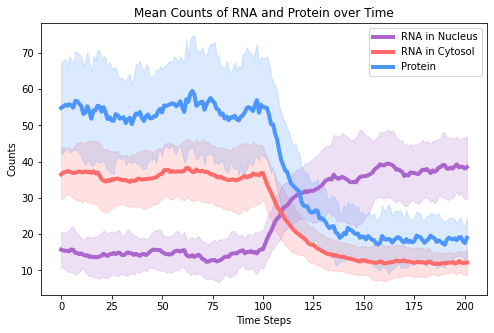

In [20]:
# plot_time_courses_species
plt.figure(figsize=(8, 5))
plt.plot(time_steps, mean_RNA_nucleus, label='RNA in Nucleus', color=species_colors['R_n'],lw=4)
plt.plot(time_steps, mean_RNA_cytosol, label='RNA in Cytosol', color=species_colors['R_c'],lw=4)
plt.plot(time_steps, mean_total_Protein, label='Protein', color=species_colors['P'],lw=4)
# plotting the std      
plt.fill_between(time_steps, mean_RNA_cytosol - std_RNA_cytosol, mean_RNA_cytosol + std_RNA_cytosol, color=species_colors['R_c'], alpha=0.2)
plt.fill_between(time_steps, mean_RNA_nucleus - std_RNA_nucleus, mean_RNA_nucleus + std_RNA_nucleus, color=species_colors['R_n'], alpha=0.2)    
plt.fill_between(time_steps, mean_total_Protein - std_total_Protein, mean_total_Protein + std_total_Protein, color=species_colors['P'], alpha=0.2)
plt.xlabel('Time Steps')
plt.ylabel('Counts')
plt.title('Mean Counts of RNA and Protein over Time')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


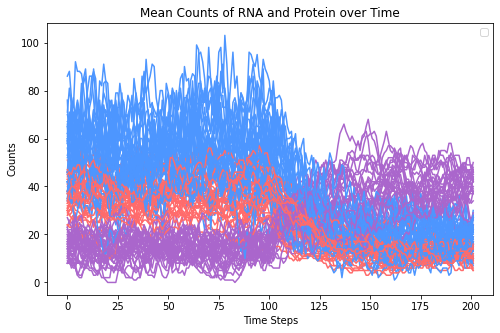

In [18]:
# plot_time_courses_species
plt.figure(figsize=(8, 5))
for i in range(number_of_trajectories):
    plt.plot(time_steps, array_RNA_nucleus[i,:], color=species_colors['R_n'])
    plt.plot(time_steps, array_RNA_cytosol[i,:], color=species_colors['R_c'])
    plt.plot(time_steps, array_total_Protein[i,:], color=species_colors['P'])
# plotting the std      
plt.xlabel('Time Steps')
plt.ylabel('Counts')
plt.title('Mean Counts of RNA and Protein over Time')
plt.legend()
plt.show()

In [19]:
raise

RuntimeError: No active exception to reraise

In [ ]:
plot_particle_positions( trajectories=results,
                           simulation_volume_size=params['simulation_volume_size'], 
                           masks_nucleus=results['nucleus_mask'], 
                           masks_cytosol=results['cytosol_mask'], 
                           simulation_type=params['simulation_type'],
                           figsize=(12, 12),
                           time_step_index=None,
                           show_axes=False,
                           elev_val=90, 
                           azim_val=-90,
                           )

# To view planes use:
# Plane   Elevation    Vertical
# XY          90         -90
# XZ           0         -90
# YZ           0           0
# Default       30         -37.5

In [ ]:
plot_particle_positions( trajectories=results,
                           simulation_volume_size=params['simulation_volume_size'], 
                           masks_nucleus=results['nucleus_mask'], 
                           masks_cytosol=results['cytosol_mask'], 
                           simulation_type=params['simulation_type'],
                           figsize=(12, 12),
                           time_step_index=23,
                           show_axes=False,
                           elev_val=90, 
                           azim_val=-90,
                           show_time_stamp=True,
                           plot_as_trajectory=False)

In [ ]:
plot_particle_positions( trajectories=results,
                           simulation_volume_size=params['simulation_volume_size'], 
                           masks_nucleus=results['nucleus_mask'], 
                           masks_cytosol=results['cytosol_mask'], 
                           simulation_type=params['simulation_type'],
                           figsize=(12, 12),
                           time_step_index=results['time_steps'][-1],
                           show_axes=False,
                           elev_val=90, 
                           azim_val=-90,
                           plot_as_trajectory=True)

In [ ]:
raise

In [ ]:
gif_image = generate_gif_multiprocessing(trajectories=results, 
                        simulation_volume_size=params['simulation_volume_size'], 
                        masks_nucleus=results['nucleus_mask'], 
                        masks_cytosol=results['cytosol_mask'], 
                        simulation_type=params['simulation_type'],
                        figsize=(12, 12), 
                        number_steps= (results['time_steps'][-1]-1)//3,
                        output_folder='temp_steps',
                        show_axes=False,
                        rotate_gif=False,
                        time_course_gif = True,
                        max_time = results['time_steps'][-1]-1,
                        gif_filename='gif_time_steps.gif',
                        plot_as_trajectory=True)
display(gif_image)

In [ ]:
if params['simulation_type'] == '3D':
    gif_image_rot = generate_gif_multiprocessing(trajectories=results, 
                            simulation_volume_size=params['simulation_volume_size'], 
                            masks_nucleus=results['nucleus_mask'], 
                            masks_cytosol=results['cytosol_mask'],
                            simulation_type=params['simulation_type'], 
                            figsize=(12, 12), 
                            time_step_index=None,
                            number_steps= 18,
                            output_folder='temp_rot',
                            show_axes=False,
                            rotate_gif=True,
                            time_course_gif = False,
                            max_time = results['time_steps'][-1]-1,
                            gif_filename='gif_rotation.gif',
                           plot_as_trajectory=False)
    display(gif_image_rot)  

In [ ]:
if params['simulation_type'] == '3D':
    gif_image_rot = generate_gif_multiprocessing(trajectories=results, 
                                simulation_volume_size=params['simulation_volume_size'], 
                                masks_nucleus=results['nucleus_mask'], 
                                masks_cytosol=results['cytosol_mask'], 
                                simulation_type=params['simulation_type'],
                                figsize=(12, 12), 
                                time_step_index=results['time_steps'][-1]-20,
                                number_steps= 9,
                                output_folder='temp_rot',
                                show_axes=False,
                                rotate_gif=True,
                                time_course_gif = False,
                                max_time = results['time_steps'][-1]-1,
                                gif_filename='gif_rotation.gif',
                                plot_as_trajectory=False)
    display(gif_image_rot)